## Proyecto de Clasificación de Imágenes de F1 - Modelo 4: Híbrido CNN-ViT con PyTorch

**Autor:** [Tu Nombre]
**Fecha:** 14 de Octubre de 2025

### Objetivo del Notebook

Este notebook completa el ciclo experimental construyendo el modelo **Híbrido CNN-Vision Transformer (ViT)** utilizando **PyTorch**. El objetivo es comparar su rendimiento directamente con la versión de Keras y con los modelos CNN más simples.

La metodología consiste en:
1.  Reutilizar el pipeline de datos de PyTorch.
2.  Definir los componentes del ViT como clases `nn.Module` personalizadas.
3.  Utilizar un backbone `EfficientNetB0` de `torchvision` como extractor de características.
4.  Ensamblar el modelo híbrido, optimizar sus hiperparámetros con **Optuna** y evaluar su rendimiento final.

In [ ]:
#Herramientas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from trainer import train_loop, val_loop 
import time

#Torch
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid 

#Optuna
import optuna

In [24]:
#Definicion Parametros Generales
DATA_DIR = "./datos"
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
SEED = 42

#Definicion de Data Augmentation
train_transforms =transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(), #convierte la imagen en un Tensor de PyTorch
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalización estándar
])

#pipeline de imagenes de validacion (sin transformaciones)
validation_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalización estándar
])

In [3]:
#Carga y division de datos

full_dataset = datasets.ImageFolder(DATA_DIR, transform=train_transforms)
class_names = full_dataset.classes
print(f"Clases encontradas: {class_names}")

#divison del dataset en train y val
val_split = 0.2
val_size = int(val_split * len(full_dataset))
train_size = len(full_dataset) - val_size
train_dataset, validation_dataset = random_split(full_dataset,[train_size, val_size])

#Sobre escribir la transformaciones del conjunto de validacion para que no use el aumeto de datos
validation_dataset.dataset.transform = validation_transforms

#Crear los DataLoaders (iteradores de los lotes de datos)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False)
print(f"\nDatasets listos: {len(train_dataset)} imágenes para entrenar, {len(validation_dataset)} para validar.")

# Verificar dispositivo gpu/cpu
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Clases encontradas: ['crash', 'f1', 'safety_car']

Datasets listos: 123 imágenes para entrenar, 30 para validar.
Usando dispositivo: cpu


Mostrando una muestra de imágenes del conjunto de entrenamiento:


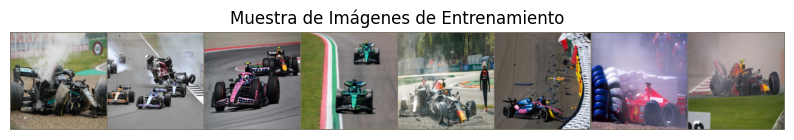


Calculando la distribución de clases...


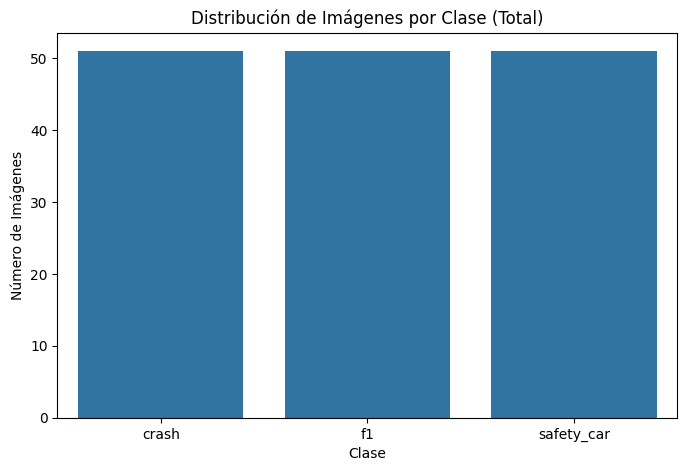

In [ ]:


#Visualizaciónes
print("Mostrando una muestra de imágenes del conjunto de entrenamiento:")

# Función para desnormalizar y mostrar la imagen 
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis("off")

#Lote de datos de entrenamiento
inputs, classes = next(iter(train_loader))

# Ploteo de las imagenes en cuadricula
plt.figure(figsize=(10,10))
out = make_grid(inputs[0:8])
imshow(out, title="Muestra de Imágenes de Entrenamiento")
plt.show()


print("\nCalculando la distribución de clases...")
class_counts = {class_name: 0 for class_name in class_names}
for _, label_idx in full_dataset.samples:
    class_name = class_names[label_idx]
    class_counts[class_name] += 1

plt.figure(figsize=(8, 5))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Distribución de Imágenes por Clase (Total)')
plt.ylabel('Número de Imágenes')
plt.xlabel('Clase')
plt.show()

### Construcción de los Componentes del Vision Transformer (ViT)

Antes de ensamblar el modelo final, definimos sus bloques de construcción como clases `nn.Module` personalizadas. Esta es la práctica estándar en PyTorch para crear arquitecturas complejas y reutilizables.

+ PatchEmbed
+ Attention
+ TransformerBlock

In [17]:
#Componentes del Vision Transformer
class PatchEmbed(nn.Module):
    """
    Convierte los mapas de características de la CNN en una secuencia de parches (tokens).
    Usa una convolución 2D con kernel 1x1 para proyectar los canales a la dimensión de embedding.
    """
    def __init__(self, in_channels, embed_dim):
        super().__init__()
        #proyeccion con una convolución 2D con kernel 1x1 
        self.proj= nn.Conv2d(in_channels, embed_dim, kernel_size=1, stride=1)

    def forward(self, x):
        # x = (Batch, Channels, Height, Width)
        x = self.proj(x)
        #dimensiones H, W aplanadas en una sola secuencia
        x = x.flatten(2)# -> (B, embed_dim, H*W)
        #reordenado para que la secuencia sea la dimensión del medio
        x = x.transpose(1, 2) # -> (B, H*W, embed_dim)
        return x
    
class Attention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        head_dim = embed_dim // num_heads
        self.scale = head_dim ** -0.5

        #capa lineal para generar q, k, v de una sola vez 
        self.qkv = nn.Linear(embed_dim, embed_dim*3, bias=False)
        self.proj = nn.Linear(embed_dim,embed_dim) #capa de proyeccion final

    def forward(self, x):
        B, N, C = x.shape
        #Obtencion de q, k, v separados en cabezales
        qkv = self.qkv(x).reshape(B,N,3,self.num_heads,C//self.num_heads).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]

        #Calculo de atencion
        attn = (q @ k.transpose(-2,-1))*self.scale
        attn = attn.softmax(dim=1)

        #output
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        return x
    
class TransformerBlock(nn.Module):
    """Bloque completo del Transformer Encoder"""
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        #atencion
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = Attention(embed_dim, num_heads=num_heads)

        #perceptron multi-capa (mlp)
        self.norm2 = nn.LayerNorm(embed_dim)
        mlp_hidden_dim = int(embed_dim*mlp_ratio)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_hidden_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        # Conexión residual + Atención
        x = x + self.attn(self.norm1(x))
        # Conexión residual + MLP
        x = x + self.mlp(self.norm2(x))
        return x

print("Componentes del Vision Transformer para PyTorch definidos.")

Componentes del Vision Transformer para PyTorch definidos.


In [15]:
class HybridViT(nn.Module):
    """
    Modelo Híbrido que combina un backbone CNN con un Transformer.
    """
    def __init__(self, cnn_backbone, num_classes, embed_dim, num_heads, num_transformer_layers):
        super().__init__()
        self.cnn_backbone = cnn_backbone
        
        #número de canales de salida del backbone
        #Encontramos la última capa convolucional del backbone
        with torch.no_grad():
            dummy_input = torch.randn(1, 3, IMAGE_SIZE[0], IMAGE_SIZE[1])
            in_channels = self.cnn_backbone(dummy_input).shape[1]

        # Componentes del Transformer
        self.patch_embed = PatchEmbed(in_channels=in_channels, embed_dim=embed_dim)
        
        # Incrustación posicional. La creamos como un parámetro entrenable.
        # El '+1' es para el token [CLS] que añadiremos.
        num_patches = self.patch_embed(self.cnn_backbone(dummy_input)).shape[1]
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches + 1, embed_dim))
        
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) # Token [CLS]
        
        # Apilamos los bloques Transformer
        self.transformer_blocks = nn.ModuleList([
            TransformerBlock(embed_dim=embed_dim, num_heads=num_heads)
            for _ in range(num_transformer_layers)
        ])
        
        self.norm = nn.LayerNorm(embed_dim)
        self.head = nn.Linear(embed_dim, num_classes) # Cabezal de clasificación

    def forward(self, x):
        # 1. Extraer características con la CNN
        x = self.cnn_backbone(x)
        
        # 2. Convertir a parches
        x = self.patch_embed(x)
        
        # 3. Añadir el token [CLS] y la incrustación posicional
        cls_tokens = self.cls_token.expand(x.shape[0], -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        x = x + self.pos_embed
        
        # 4. Pasar por los bloques Transformer
        for blk in self.transformer_blocks:
            x = blk(x)
            
        # 5. Normalizar y clasificar usando solo el token [CLS]
        x = self.norm(x)
        return self.head(x[:, 0])



In [18]:
#Hiperparámetros y Construcción del Modelo
NUM_TRANSFORMER_LAYERS = 4
NUM_HEADS = 4
EMBED_DIM = 256 # Dimensión interna del Transformer
NUM_CLASSES = len(class_names)
#Carga de EfficientNet congelado
cnn_base = models.efficientnet_b0(weights='IMAGENET1K_V1')
for param in cnn_base.parameters():
    param.requires_grad = False

#Creamos el backbone CNN (quitamos el cabezal de clasificación original)
cnn_backbone = nn.Sequential(*list(cnn_base.children())[:-2])

#Creamos la instancia de nuestro modelo híbrido
hybrid_model = HybridViT(
    cnn_backbone=cnn_backbone,
    num_classes=NUM_CLASSES,
    embed_dim=EMBED_DIM,
    num_heads=NUM_HEADS,
    num_transformer_layers=NUM_TRANSFORMER_LAYERS
).to(device)

#Definimos el optimizador (solo para los parámetros que NO están congelados)
optimizer = torch.optim.Adam(hybrid_model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

print("Modelo Híbrido PyTorch construido y listo para entrenar.")
# Descomenta la siguiente línea para ver la arquitectura
# print(hybrid_model)

Modelo Híbrido PyTorch construido y listo para entrenar.


Iniciando el entrenamiento del modelo híbrido...

Época 1/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 8.32s | Train Loss: 1.1977 | Train Acc: 0.5447 | Val Loss: 1.3659 | Val Acc: 0.5333
=> Modelo híbrido guardado (mejor Acc de validación)

Época 2/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 7.02s | Train Loss: 0.4070 | Train Acc: 0.8780 | Val Loss: 0.8737 | Val Acc: 0.6667
=> Modelo híbrido guardado (mejor Acc de validación)

Época 3/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 6.82s | Train Loss: 0.3782 | Train Acc: 0.8699 | Val Loss: 0.8656 | Val Acc: 0.7333
=> Modelo híbrido guardado (mejor Acc de validación)

Época 4/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 7.41s | Train Loss: 0.2571 | Train Acc: 0.9268 | Val Loss: 1.0007 | Val Acc: 0.7667
=> Modelo híbrido guardado (mejor Acc de validación)

Época 5/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 7.03s | Train Loss: 0.1888 | Train Acc: 0.9512 | Val Loss: 0.7877 | Val Acc: 0.7667

Época 6/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 6.70s | Train Loss: 0.1671 | Train Acc: 0.9106 | Val Loss: 0.9994 | Val Acc: 0.7667

Época 7/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 6.60s | Train Loss: 0.0993 | Train Acc: 0.9837 | Val Loss: 1.1282 | Val Acc: 0.7667

Época 8/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 7.07s | Train Loss: 0.0362 | Train Acc: 0.9837 | Val Loss: 1.0109 | Val Acc: 0.8000
=> Modelo híbrido guardado (mejor Acc de validación)

Época 9/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 7.20s | Train Loss: 0.0364 | Train Acc: 0.9919 | Val Loss: 1.2668 | Val Acc: 0.7333

Época 10/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 7.18s | Train Loss: 0.1075 | Train Acc: 0.9675 | Val Loss: 0.7862 | Val Acc: 0.8000

Época 11/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 7.30s | Train Loss: 0.0516 | Train Acc: 0.9837 | Val Loss: 1.3418 | Val Acc: 0.7667

Época 12/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 6.48s | Train Loss: 0.0808 | Train Acc: 0.9837 | Val Loss: 0.7273 | Val Acc: 0.8667
=> Modelo híbrido guardado (mejor Acc de validación)

Época 13/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 6.68s | Train Loss: 0.1635 | Train Acc: 0.9593 | Val Loss: 1.2688 | Val Acc: 0.7667

Época 14/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 6.70s | Train Loss: 0.0709 | Train Acc: 0.9756 | Val Loss: 1.2593 | Val Acc: 0.7667

Época 15/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 7.14s | Train Loss: 0.0919 | Train Acc: 0.9756 | Val Loss: 1.1875 | Val Acc: 0.7333

Época 16/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 6.99s | Train Loss: 0.0826 | Train Acc: 0.9593 | Val Loss: 0.9519 | Val Acc: 0.7000

Época 17/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 6.68s | Train Loss: 0.0507 | Train Acc: 0.9837 | Val Loss: 0.8881 | Val Acc: 0.8333

Época 18/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 6.55s | Train Loss: 0.1134 | Train Acc: 0.9837 | Val Loss: 1.0732 | Val Acc: 0.8333

Época 19/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 6.60s | Train Loss: 0.0490 | Train Acc: 0.9919 | Val Loss: 0.9459 | Val Acc: 0.8333

Época 20/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 6.81s | Train Loss: 0.1250 | Train Acc: 0.9593 | Val Loss: 0.7142 | Val Acc: 0.8000

Época 21/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 7.05s | Train Loss: 0.0969 | Train Acc: 0.9675 | Val Loss: 0.8606 | Val Acc: 0.8333

Época 22/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 7.17s | Train Loss: 0.5715 | Train Acc: 0.8618 | Val Loss: 0.8690 | Val Acc: 0.7667

Época 23/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 6.86s | Train Loss: 0.2330 | Train Acc: 0.9106 | Val Loss: 0.6715 | Val Acc: 0.7667

Época 24/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 6.61s | Train Loss: 0.2272 | Train Acc: 0.9268 | Val Loss: 0.4089 | Val Acc: 0.8667

Época 25/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 6.65s | Train Loss: 0.0826 | Train Acc: 0.9837 | Val Loss: 0.5524 | Val Acc: 0.8333

Época 26/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 6.66s | Train Loss: 0.0873 | Train Acc: 0.9756 | Val Loss: 0.6224 | Val Acc: 0.7667

Época 27/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 6.61s | Train Loss: 0.1466 | Train Acc: 0.9350 | Val Loss: 0.9709 | Val Acc: 0.8000

Época 28/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 6.68s | Train Loss: 0.2014 | Train Acc: 0.9675 | Val Loss: 0.5366 | Val Acc: 0.7667

Época 29/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 6.80s | Train Loss: 0.1893 | Train Acc: 0.9512 | Val Loss: 0.4227 | Val Acc: 0.8000

Época 30/30


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Duración: 6.99s | Train Loss: 0.1363 | Train Acc: 0.9593 | Val Loss: 0.5043 | Val Acc: 0.8333

¡Entrenamiento completado!


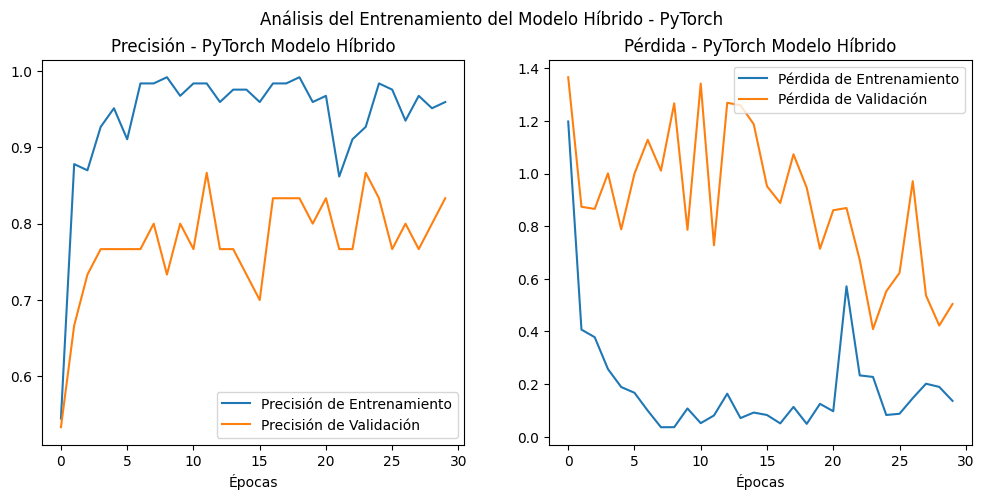

In [ ]:
#Entrenamiento y Evaluacion

#Bucle Principal de Entrenamiento 
NUM_EPOCHS = 30
best_val_acc = 0.0
history_hybrid = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}

print("Iniciando el entrenamiento del modelo híbrido...")
for epoch in range(NUM_EPOCHS):
    start_time = time.time()
    print(f"\nÉpoca {epoch+1}/{NUM_EPOCHS}")
    
    train_loss, train_acc = train_loop(hybrid_model, device, train_loader, criterion, optimizer)
    val_loss, val_acc = val_loop(hybrid_model, device, validation_loader, criterion)

    history_hybrid['train_loss'].append(train_loss)
    history_hybrid['train_acc'].append(train_acc)
    history_hybrid['val_loss'].append(val_loss)
    history_hybrid['val_acc'].append(val_acc)
    
    epoch_duration = time.time() - start_time
    print(f"Duración: {epoch_duration:.2f}s | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(hybrid_model.state_dict(), 'f1_classifier_pytorch_hybrid.pth')
        print("=> Modelo híbrido guardado (mejor Acc de validación)")

print("\n¡Entrenamiento completado!")

#Visualización de las Curvas de Entrenamiento
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_hybrid['train_acc'], label='Precisión de Entrenamiento')
plt.plot(history_hybrid['val_acc'], label='Precisión de Validación')
plt.legend(), plt.title('Precisión - PyTorch Modelo Híbrido'), plt.xlabel('Épocas')
plt.subplot(1, 2, 2)
plt.plot(history_hybrid['train_loss'], label='Pérdida de Entrenamiento')
plt.plot(history_hybrid['val_loss'], label='Pérdida de Validación')
plt.legend(), plt.title('Pérdida - PyTorch Modelo Híbrido'), plt.xlabel('Épocas')
plt.suptitle('Análisis del Entrenamiento del Modelo Híbrido - PyTorch')
plt.show()

C:\Users\Urano\AppData\Local\Temp\ipykernel_8428\2107245535.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hybrid_model.load_state_dict(torch.load('f1_classifier_pytorc

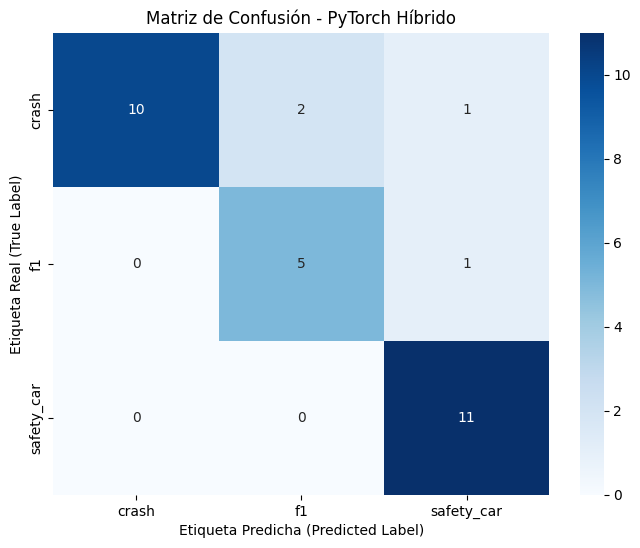


     REPORTE DE CLASIFICACIÓN - PYTORCH HÍBRIDO
              precision    recall  f1-score   support

       crash       1.00      0.77      0.87        13
          f1       0.71      0.83      0.77         6
  safety_car       0.85      1.00      0.92        11

    accuracy                           0.87        30
   macro avg       0.85      0.87      0.85        30
weighted avg       0.89      0.87      0.87        30



In [21]:
#Analisis de Rendimiento

from sklearn.metrics import confusion_matrix, classification_report

# Cargamos los pesos del mejor modelo que guardamos durante el entrenamiento
hybrid_model.load_state_dict(torch.load('f1_classifier_pytorch_hybrid.pth'))
hybrid_model.eval() # Poner el modelo en modo de evaluación

y_pred = []
y_true = []

# Iteramos sobre el dataset de validación para obtener las predicciones
with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        outputs = hybrid_model(inputs)
        _, preds = torch.max(outputs, 1)
        
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Generamos la Matriz de Confusión
conf_matrix = confusion_matrix(y_true, y_pred)

# Visualizamos la Matriz de Confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Etiqueta Predicha (Predicted Label)')
plt.ylabel('Etiqueta Real (True Label)')
plt.title('Matriz de Confusión - PyTorch Híbrido')
plt.show()

# Imprimimos el Reporte de Clasificación
print("\n" + "="*60)
print("     REPORTE DE CLASIFICACIÓN - PYTORCH HÍBRIDO")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names))
print("="*60)

### Análisis de Resultados: PyTorch Híbrido

* Rendimiento General: Con un __87%__ de precisión (accuracy), el modelo es competente y ha aprendido patrones útiles. Sin embargo, no alcanza la excelencia del __90-97%__ que vimos en los otros modelos.

* Signos de Sobreajuste: Hay una diferencia notable entre la precisión de entrenamiento __(98.4%)__ y la de validación __(86.7%)__. Esta brecha de __~12%__ indica un ligero sobreajuste, lo que sugiere que el modelo se adapta un poco más a los datos que ya ha visto.

* Puntos Fuertes: El modelo es perfecto para encontrar todos los safety_car (recall de 1.00) y nunca se equivoca al predecir un crash (precisión de 1.00).

* Punto Débil Principal: Su principal área de mejora es la precisión para __la clase f1 (71%)__. Esto significa que casi un __30%__ de las veces que el modelo dice _"esto es un F1"_, en realidad se está confundiendo con otra clase.

* El resultado de __87%__ _no es lo suficientemente bueno como para justificar no optimizarlo_, especialmente cuando nuestros otros modelos superaron el __90%.__


### Optimización de Hiperparámetros con Optuna

Al igual que en los casos anteriores, el rendimiento del modelo base puede ser mejorado. Para encontrar la configuración óptima de esta compleja arquitectura, utilizamos **Optuna**.

Se define una función `objective` donde se construye y entrena el modelo híbrido con diferentes valores para los siguientes hiperparámetros:
- **Tasa de Aprendizaje (`lr`)**
- **Número de capas Transformer (`num_transformer_layers`)**
- **Dimensión del Embedding (`embed_dim`)**
- **Número de Cabezales de Atención (`num_heads`)**

El estudio de Optuna buscará la combinación que maximice la `val_accuracy`.

In [ ]:
#Optimizacion con Optuna

def objective_hybrid(trial):
    #Espacio de Búsqueda
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    num_transformer_layers = trial.suggest_int("num_transformer_layers", 2, 6)
    embed_dim = trial.suggest_categorical("embed_dim", [128, 256])
    num_heads = trial.suggest_categorical("num_heads", [2, 4])

    #Modelo Híbrido
    cnn_base = models.efficientnet_b0(weights='IMAGENET1K_V1')
    for param in cnn_base.parameters():
        param.requires_grad = False
    cnn_backbone = nn.Sequential(*list(cnn_base.children())[:-2])
    
    model = HybridViT(
        cnn_backbone=cnn_backbone,
        num_classes=NUM_CLASSES,
        embed_dim=embed_dim,
        num_heads=num_heads,
        num_transformer_layers=num_transformer_layers
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    #Bucle de Entrenamiento y Validación 
    for epoch in range(15): # Entrenamos 15 épocas por trial
        train_loop(model, device, train_loader, criterion, optimizer)

    # Evaluacion y metricas
    val_loss, val_acc = val_loop(model, device, validation_loader, criterion)
    
    return val_acc

#Optimizacion
study_hybrid = optuna.create_study(direction="maximize")
study_hybrid.optimize(objective_hybrid, n_trials=15) 

print("\n¡Búsqueda completada para el modelo híbrido de PyTorch!")
print("Mejor trial:")
trial = study_hybrid.best_trial
print(f"  Valor (val_accuracy): {trial.value:.4f}")
print("  Mejores Hiperparámetros: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

[I 2025-10-13 11:40:37,349] A new study created in memory with name: no-name-a43a9309-beee-43f4-8b99-7ad0b8dae1c7


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

[I 2025-10-13 11:41:56,377] Trial 0 finished with value: 0.9 and parameters: {'lr': 0.0036418071572598613, 'num_transformer_layers': 3, 'embed_dim': 256, 'num_heads': 4}. Best is trial 0 with value: 0.9.


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

[I 2025-10-13 11:43:12,449] Trial 1 finished with value: 0.6666666666666666 and parameters: {'lr': 0.0006185394251046578, 'num_transformer_layers': 6, 'embed_dim': 128, 'num_heads': 2}. Best is trial 0 with value: 0.9.


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

[I 2025-10-13 11:44:23,635] Trial 2 finished with value: 0.7333333333333333 and parameters: {'lr': 3.888220461541445e-05, 'num_transformer_layers': 2, 'embed_dim': 128, 'num_heads': 4}. Best is trial 0 with value: 0.9.


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

[I 2025-10-13 11:45:37,973] Trial 3 finished with value: 0.8 and parameters: {'lr': 0.0002369150851837022, 'num_transformer_layers': 5, 'embed_dim': 128, 'num_heads': 4}. Best is trial 0 with value: 0.9.


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

[I 2025-10-13 11:46:52,066] Trial 4 finished with value: 0.6333333333333333 and parameters: {'lr': 0.00011408889981650151, 'num_transformer_layers': 5, 'embed_dim': 128, 'num_heads': 2}. Best is trial 0 with value: 0.9.


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

[I 2025-10-13 11:48:09,757] Trial 5 finished with value: 0.7 and parameters: {'lr': 0.008831741751320408, 'num_transformer_layers': 3, 'embed_dim': 256, 'num_heads': 4}. Best is trial 0 with value: 0.9.


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

[I 2025-10-13 11:49:28,611] Trial 6 finished with value: 0.8333333333333334 and parameters: {'lr': 0.00015846017919863458, 'num_transformer_layers': 3, 'embed_dim': 256, 'num_heads': 2}. Best is trial 0 with value: 0.9.


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

[I 2025-10-13 11:50:49,460] Trial 7 finished with value: 0.7 and parameters: {'lr': 0.00022065629154600992, 'num_transformer_layers': 4, 'embed_dim': 256, 'num_heads': 4}. Best is trial 0 with value: 0.9.


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

[I 2025-10-13 11:52:02,546] Trial 8 finished with value: 0.6 and parameters: {'lr': 1.3712821261796301e-05, 'num_transformer_layers': 4, 'embed_dim': 128, 'num_heads': 4}. Best is trial 0 with value: 0.9.


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

[I 2025-10-13 11:53:16,456] Trial 9 finished with value: 0.8666666666666667 and parameters: {'lr': 5.6698539377133233e-05, 'num_transformer_layers': 4, 'embed_dim': 128, 'num_heads': 4}. Best is trial 0 with value: 0.9.


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

[I 2025-10-13 11:54:33,056] Trial 10 finished with value: 0.7333333333333333 and parameters: {'lr': 0.0038441998747498073, 'num_transformer_layers': 2, 'embed_dim': 256, 'num_heads': 2}. Best is trial 0 with value: 0.9.


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

[I 2025-10-13 11:55:50,829] Trial 11 finished with value: 0.8666666666666667 and parameters: {'lr': 0.0010843343099990231, 'num_transformer_layers': 3, 'embed_dim': 256, 'num_heads': 4}. Best is trial 0 with value: 0.9.


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

[I 2025-10-13 11:57:04,043] Trial 12 finished with value: 0.7666666666666667 and parameters: {'lr': 4.3697096711063384e-05, 'num_transformer_layers': 4, 'embed_dim': 128, 'num_heads': 4}. Best is trial 0 with value: 0.9.


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

[I 2025-10-13 11:58:27,941] Trial 13 finished with value: 0.8333333333333334 and parameters: {'lr': 0.0016888350760562226, 'num_transformer_layers': 5, 'embed_dim': 256, 'num_heads': 4}. Best is trial 0 with value: 0.9.


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

[I 2025-10-13 11:59:39,908] Trial 14 finished with value: 0.5666666666666667 and parameters: {'lr': 1.0792234263015525e-05, 'num_transformer_layers': 3, 'embed_dim': 128, 'num_heads': 4}. Best is trial 0 with value: 0.9.



¡Búsqueda completada para el modelo híbrido de PyTorch!
Mejor trial:
  Valor (val_accuracy): 0.9000
  Mejores Hiperparámetros: 
    lr: 0.0036418071572598613
    num_transformer_layers: 3
    embed_dim: 256
    num_heads: 4


In [25]:
# Evaluacion y entrenamiento final con HP Optuna

# Mejores Hiperparámetros Encontrados por Optuna
best_params = study_hybrid.best_trial.params
print("Usando los Hiperparámetros Óptimos")
print(best_params)

#Modelo Final Optimizado
final_hybrid_model = HybridViT(
    cnn_backbone=cnn_backbone,
    num_classes=NUM_CLASSES,
    embed_dim=best_params['embed_dim'],
    num_heads=best_params['num_heads'],
    num_transformer_layers=best_params['num_transformer_layers']
).to(device)

optimizer = torch.optim.Adam(final_hybrid_model.parameters(), lr=best_params['lr'])
criterion = nn.CrossEntropyLoss()


Usando los Hiperparámetros Óptimos
{'lr': 0.0036418071572598613, 'num_transformer_layers': 3, 'embed_dim': 256, 'num_heads': 4}


In [26]:
#Entrenar el Modelo Final
NUM_EPOCHS_FINAL = 30 # Entrenamos por más épocas para que converja
best_val_acc = 0.0
history_final = {
    'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []
}

print("\nIniciando el entrenamiento del modelo híbrido final...")
for epoch in range(NUM_EPOCHS_FINAL):
    start_time = time.time()
    train_loss, train_acc = train_loop(final_hybrid_model, device, train_loader, criterion, optimizer)
    val_loss, val_acc = val_loop(final_hybrid_model, device, validation_loader, criterion)

    history_final['train_loss'].append(train_loss)
    history_final['train_acc'].append(train_acc)
    history_final['val_loss'].append(val_loss)
    history_final['val_acc'].append(val_acc)
    
    print(f"Época {epoch+1}/{NUM_EPOCHS_FINAL} | Duración: {time.time() - start_time:.2f}s | Val Acc: {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(final_hybrid_model.state_dict(), 'f1_classifier_pytorch_hybrid_OPTIMIZED.pth')
        print("=> Modelo final guardado (mejor Acc)")

print("\n¡Entrenamiento Final Completado!")



Iniciando el entrenamiento del modelo híbrido final...


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 1/30 | Duración: 6.84s | Val Acc: 0.6667
=> Modelo final guardado (mejor Acc)


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 2/30 | Duración: 6.83s | Val Acc: 0.7667
=> Modelo final guardado (mejor Acc)


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 3/30 | Duración: 6.67s | Val Acc: 0.8333
=> Modelo final guardado (mejor Acc)


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 4/30 | Duración: 6.41s | Val Acc: 0.8667
=> Modelo final guardado (mejor Acc)


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 5/30 | Duración: 6.31s | Val Acc: 0.8333


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 6/30 | Duración: 6.58s | Val Acc: 0.8000


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 7/30 | Duración: 6.36s | Val Acc: 0.9000
=> Modelo final guardado (mejor Acc)


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 8/30 | Duración: 6.46s | Val Acc: 0.8667


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 9/30 | Duración: 6.23s | Val Acc: 0.9000


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 10/30 | Duración: 6.17s | Val Acc: 0.8667


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 11/30 | Duración: 6.25s | Val Acc: 0.8667


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 12/30 | Duración: 6.19s | Val Acc: 0.8667


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 13/30 | Duración: 6.19s | Val Acc: 0.8667


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 14/30 | Duración: 6.16s | Val Acc: 0.8667


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 15/30 | Duración: 6.15s | Val Acc: 0.8667


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 16/30 | Duración: 6.17s | Val Acc: 0.8333


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 17/30 | Duración: 6.22s | Val Acc: 0.8333


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 18/30 | Duración: 6.13s | Val Acc: 0.8667


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 19/30 | Duración: 6.21s | Val Acc: 0.7333


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 20/30 | Duración: 6.26s | Val Acc: 0.8333


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 21/30 | Duración: 6.20s | Val Acc: 0.9333
=> Modelo final guardado (mejor Acc)


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 22/30 | Duración: 6.23s | Val Acc: 0.9000


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 23/30 | Duración: 6.24s | Val Acc: 0.9000


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 24/30 | Duración: 6.24s | Val Acc: 0.9333


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 25/30 | Duración: 6.20s | Val Acc: 0.9333


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 26/30 | Duración: 6.14s | Val Acc: 0.9000


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 27/30 | Duración: 6.11s | Val Acc: 0.9000


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 28/30 | Duración: 6.23s | Val Acc: 0.9000


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 29/30 | Duración: 6.28s | Val Acc: 0.9000


Entrenando:   0%|          | 0/8 [00:00<?, ?it/s]

Validadndo:   0%|          | 0/2 [00:00<?, ?it/s]

Época 30/30 | Duración: 6.14s | Val Acc: 0.8667

¡Entrenamiento Final Completado!


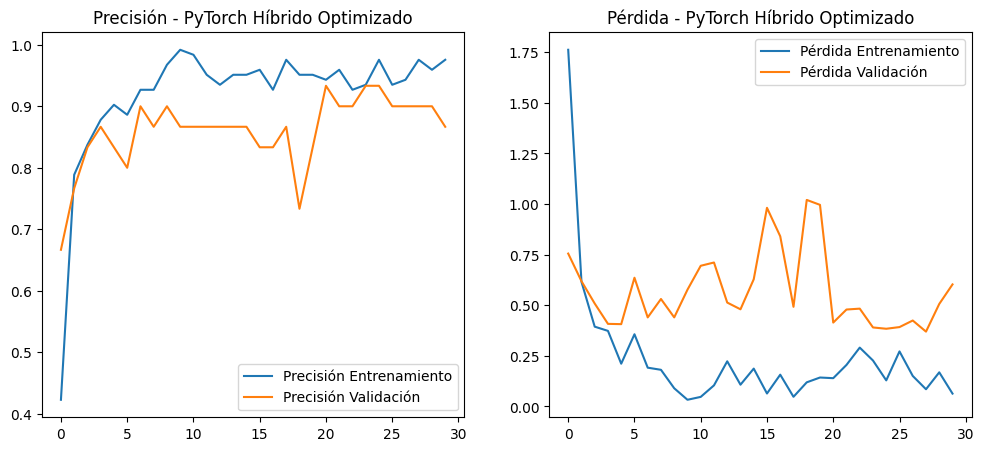

C:\Users\Urano\AppData\Local\Temp\ipykernel_8428\596911859.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  final_hybrid_model.load_state_dict(torch.load('f1_classifier_

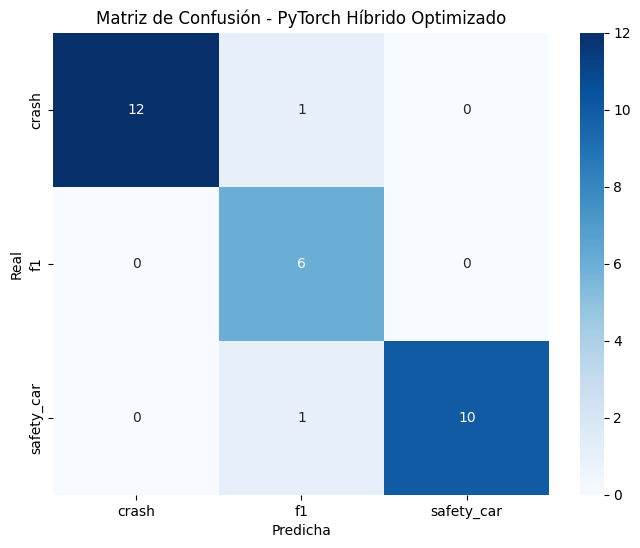


     REPORTE DE CLASIFICACIÓN - PYTORCH HÍBRIDO OPTIMIZADO
              precision    recall  f1-score   support

       crash       1.00      0.92      0.96        13
          f1       0.75      1.00      0.86         6
  safety_car       1.00      0.91      0.95        11

    accuracy                           0.93        30
   macro avg       0.92      0.94      0.92        30
weighted avg       0.95      0.93      0.94        30



In [27]:
#Visualizar las Curvas del Modelo Optimizado
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_final['train_acc'], label='Precisión Entrenamiento')
plt.plot(history_final['val_acc'], label='Precisión Validación')
plt.legend(), plt.title('Precisión - PyTorch Híbrido Optimizado')

plt.subplot(1, 2, 2)
plt.plot(history_final['train_loss'], label='Pérdida Entrenamiento')
plt.plot(history_final['val_loss'], label='Pérdida Validación')
plt.legend(), plt.title('Pérdida - PyTorch Híbrido Optimizado')
plt.show()

#Análisis Detallado Final
final_hybrid_model.load_state_dict(torch.load('f1_classifier_pytorch_hybrid_OPTIMIZED.pth'))
final_hybrid_model.eval()

y_pred, y_true = [], []
with torch.no_grad():
    for inputs, labels in validation_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = final_hybrid_model(inputs)
        _, preds = torch.max(outputs, 1)
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicha'), plt.ylabel('Real'), plt.title('Matriz de Confusión - PyTorch Híbrido Optimizado')
plt.show()

print("\n" + "="*60)
print("     REPORTE DE CLASIFICACIÓN - PYTORCH HÍBRIDO OPTIMIZADO")
print("="*60)
print(classification_report(y_true, y_pred, target_names=class_names))
print("="*60)

### Resultados: Modelo Híbrido Optimizado

La optimización de hiperparámetros del modelo híbrido CNN-ViT ha sido un éxito, resultando en un clasificador de muy alto rendimiento con una precisión general del __93%__.

### Análisis de Resultados: PyTorch Híbrido Optimizado
* Con una precisión general del __93%__, este modelo es _ahora muy robusto_.

* Puntos Fuertes: El modelo es perfecto para encontrar todos los coches de f1 (recall de 1.00) y es infalible cuando predice crash o safety_car (precisión de 1.00 para ambas). Esto significa que _no genera falsos positivos para estas dos clases._

* Punto Débil Principal: Su única debilidad notable sigue siendo la precisión de la clase f1 __(75%)__. Esto nos dice que, aunque encuentra todos los F1, _a veces se confunde y clasifica erróneamente_ un crash o un safety_car como si fuera un f1, igualmente es una mejoria respecto al modelo sin optimizar.


## Conclusión del Notebook

El modelo híbrido en PyTorch, tras la optimización con Optuna, alcanzó una excelente precisión del **93%**. Este resultado lo posiciona como un modelo de alto rendimiento, comparable a su contraparte en Keras. Con la finalización de este notebook, se concluye la fase de construcción de los cuatro modelos experimentales del proyecto. Todos los resultados están listos para ser analizados en la fase de comparación final.